In [ ]:
%load_ext autoreload
%autoreload 2
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

In [ ]:
import tabulate
from scripts.wandb_experiments.static_texture_benchmark import (
    TexturingGeometryAndPrompts,
)
from text3d2video.util import concat_lists

mando = TexturingGeometryAndPrompts(
    "mv_helmet:latest",
    ["A Mandalorian Helmet in Silver", "Jango Fett Helmet", "Boba Fett Helmet"],
)
cat_statue = TexturingGeometryAndPrompts(
    "cat_statue_mv:latest", ["Metalic Cat Statue", "Cat Statue"]
)
backpack = TexturingGeometryAndPrompts("mv_backpack:latest", ["A 3D Backpack"])
human = TexturingGeometryAndPrompts(
    "human_mv:latest", ["Deadpool", "Stormtrooper", "Abraham Lincoln"]
)
lion = TexturingGeometryAndPrompts(
    "mv_lion:latest", ["A cute 3D cartoon lion with brown hair", "A marble lion"]
)

inputs = [mando, cat_statue, human, backpack, lion]
scenes = concat_lists(s.to_scenes() for s in inputs)
print(tabulate.tabulate([s.tabulate_row() for s in scenes], headers="keys"))

In [ ]:
from itertools import product
from omegaconf import OmegaConf

from scripts.wandb_experiments.static_texture_benchmark import TexturingMethod
from scripts.wandb_runs.make_texture import MakeTextureConfig
from text3d2video.pipelines.pipeline_utils import ModelConfig
from text3d2video.pipelines.texturing_pipeline import TexturingConfig
from text3d2video.utilities.omegaconf_util import omegaconf_from_dotdict

base = OmegaConf.structured(
    MakeTextureConfig(
        prompt="",
        animation_tag="",
        model=ModelConfig(),
        texgen=TexturingConfig(use_update_masks=False, use_prev_clean_tex=False),
    )
)

sweep_dict = {
    # "texgen.do_text_and_texture_resampling": [True, False],
    # 'texgen.use_reference_kvs': [True, False],
    "texgen.use_update_masks": [True, False],
    "texgen.use_prev_clean_tex": [True, False],
}


keys = list(sweep_dict.keys())
values_product = list(product(*[sweep_dict[k] for k in keys]))

methods = []
for values in values_product:
    overrides = omegaconf_from_dotdict(dict(zip(keys, values)))
    new_cfg = OmegaConf.merge(base, overrides)

    name = "TexGen"
    if overrides.texgen.use_update_masks:
        name += " + UV Update Masks"
    if overrides.texgen.use_prev_clean_tex:
        name += "+ Prev Clean Tex"

    methods.append(TexturingMethod(name=name, base_config=new_cfg))


print(
    tabulate.tabulate(
        [m.tabulate_row(flat_config=True) for m in methods], headers="keys"
    )
)

In [4]:
from scripts.wandb_experiments.static_texture_benchmark import (
    TexturingBenchmarkConfig,
    texturing_benchmark,
)

config = OmegaConf.create(TexturingBenchmarkConfig(scenes, methods))

spec = texturing_benchmark(config)

In [ ]:
import wandb_util.wandb_util as wbu

wbu.sync_experiment(texturing_benchmark, config, "texutre_benchmark")

In [6]:
exp_name = "texutre_benchmark"
runs = wbu.get_logged_runs(exp_name)

In [ ]:
from text3d2video.util import group_into_array, map_array
from text3d2video.utilities.ipython_utils import display_ims_grid


def scene_key(run):
    config = OmegaConf.create(run.config)
    return f"{config.animation_tag}-{config.prompt}"


def method_key(run):
    return run.name.split("_")[0]


runs_grouped, labels = group_into_array(runs, [method_key, scene_key])
runs_grouped.shape


In [ ]:
from text3d2video.experiment_analysis import MakeTextureTraces

runs_data = map_array(runs_grouped, MakeTextureTraces.from_run, pbar=True)

In [ ]:
textures = map_array(runs_data, lambda r: r.texture_pil)

display_ims_grid(textures)

In [ ]:
from text3d2video.utilities.video_comparison import video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

vids = map_array(runs_data, lambda r: pil_frames_to_clip(r.frames, fps=5))
grid = video_grid(vids, y_labels=labels[0])
grid.write_videofile("outs/texturing_benchmark.mp4")

In [496]:
from einops import rearrange
from matplotlib import pyplot as plt
import numpy as np
from text3d2video.util import map_object_array, object_array
from text3d2video.utilities.matplotlib_utils import (
    make_grid,
)

frame_indices = [1, 2, 3]
scenes = [1, 7]
methods = [0, 2]

fig_runs = runs_data[np.ix_(methods, scenes)]

ims = map_object_array(
    fig_runs, lambda r: object_array([r.frames[i] for i in frame_indices])
)


ims = rearrange(ims, "method scene frame -> scene method frame")

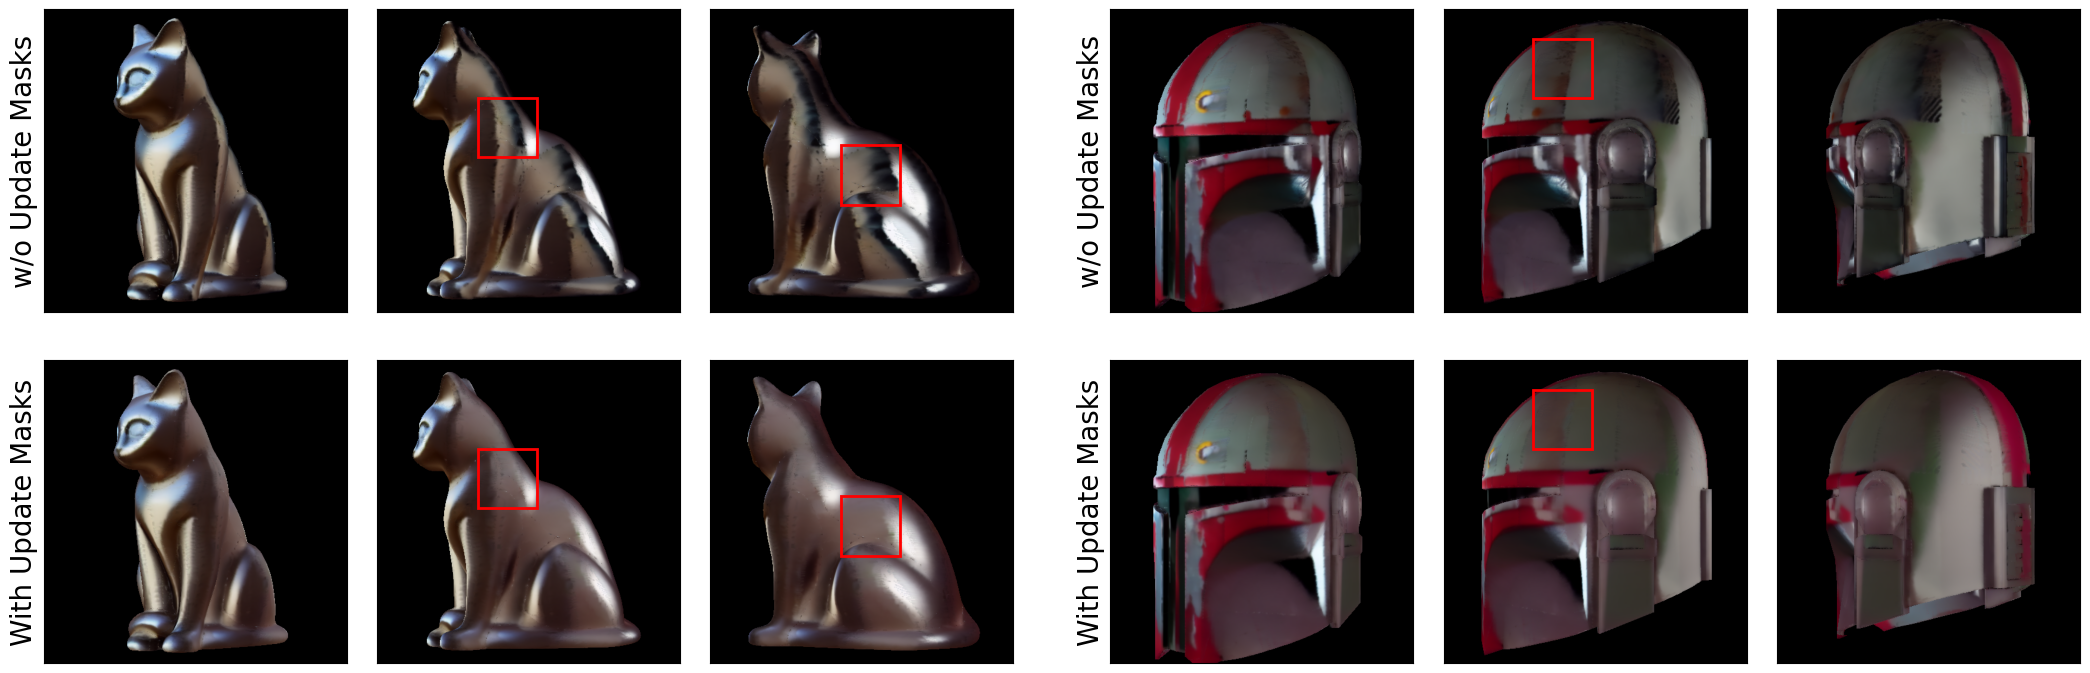

In [545]:
from text3d2video.utilities.matplotlib_utils import (
    bbox_around_point,
    rectangle_from_bbox,
)


dim_labels = {
    1: ["w/o Update Masks", "With Update Masks"],
}

fig, axs = make_grid(
    list(ims.shape),
    scale=3.5,
    gap=0.1,
    dim_labels=dim_labels,
)

for idx, ax in np.ndenumerate(axs):
    ax.imshow(ims[idx])

plt.savefig("outs/with_update_masks.pdf")

# scene method frame
frame_axs = axs[0, :, 1]
for ax in frame_axs:
    bbox = bbox_around_point([220, 200], 100)
    rect = rectangle_from_bbox(bbox)
    ax.add_patch(rect)

frame_axs = axs[0, :, 2]
for ax in frame_axs:
    bbox = bbox_around_point([270, 280], 100)
    rect = rectangle_from_bbox(bbox)
    ax.add_patch(rect)

frame_axs = axs[1, :, 1]
for ax in frame_axs:
    bbox = bbox_around_point([200, 100], 100)
    rect = rectangle_from_bbox(bbox)
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig("outs/mpl_figs/with_update_masks.pdf")